In [5]:
!pip install pandas

! pip install matplotlib

  Using cached contourpy-1.3.3-cp313-cp313-macosx_11_0_arm64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pillow-11.3.0-cp313-cp313-macosx_11_0_arm64.whl.metadata (9.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 34.1 MB/s  0:00:00 eta 0:00:01
Using cached contourpy-1.3.3-cp313-cp313-macosx_11_0_arm64.whl (274 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 64.8 MB/s  0:00:00
Using cached pillow-11.3.0-cp313-cp313-macosx_11_0_arm64.whl (4.7 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [matplotlib]7 [matplotlib]


In [6]:
import os, re, math
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


Loads sales data and nutrition data.

Creates an eda_outputs/ folder to save all cleaned outputs and issue reports.

In [7]:
SALES_CSV = "/Users/sirishag/Documents/fall-2025-group8/src/data/sales.csv"
NUTR_CSV  = "/Users/sirishag/Documents/fall-2025-group8/src/data/nutrition items.csv"
OUT_DIR   = "/Users/sirishag/Documents/fall-2025-group8/src/data/eda_outputs"
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)


In [8]:
sales = pd.read_csv(SALES_CSV)
nutr  = pd.read_csv(NUTR_CSV)


Removes unit columns (Calories_Unit, etc.) since they are redundant.

Cleans whitespace and missing text from sales descriptions.

In [9]:
nutr.columns = nutr.columns.str.strip()
nutr = nutr.drop(columns=[c for c in nutr.columns if c.endswith("_Unit")], errors="ignore")
sales["description"] = sales["description"].astype(str).fillna("").str.strip()

print(f"Sales shape: {sales.shape} | Nutrition shape: {nutr.shape}")

Sales shape: (224536, 19) | Nutrition shape: (1298648, 40)


Converts text to lowercase, removes symbols, standardizes things like w/ → with.

Uses keyword rules to tag items (e.g., “Honey Nut Cheerios” → category cereal).

Helps group generic sales items like “CEREAL MEAL” with their detailed recipe variants.

In [10]:

# ---------- HELPERS ----------
def norm(s: str) -> str:
    if pd.isna(s): return ""
    s = str(s).lower().replace("&"," and ")
    s = re.sub(r"\bw\/\b"," with ", s)   # w/ -> with
    s = re.sub(r"\/"," ", s)             # "/" -> space
    s = re.sub(r"[^a-z0-9\s%+]", " ", s) # keep %, +
    return re.sub(r"\s+", " ", s).strip()

CATEGORY_RULES = {
    "cereal": ["cereal","cheerios","chex","toast crunch","kix","krispies","corn flakes","raisin bran"],
    "bagel": ["bagel"],
    "cream_cheese": ["cream cheese"],
    "parfait": ["parfait"],
    "milk": ["milk","1%","one percent","fat free","lowfat","chocolate milk"],
    "juice": ["juice","apple juice","orange juice","grape juice"],
    "fruit": ["apple","banana","orange","mandarin","clementine","grape","pear","peach","pineapple","berries","fruit"],
    "biscuit": ["biscuit"],
    "muffin": ["muffin"],
    "egg": ["egg"],
    "cheese": ["cheese","american cheese","string cheese","cream cheese"],
    "yogurt": ["yogurt"],
    "bread": ["bread","muffin top","english muffin"],
    "pancake": ["pancake","waffle","french toast"],
    "sausage": ["sausage"],
    "sandwich": ["sandwich","burger","hot dog"],
    "water": ["water","bottled water"],
    "cookie": ["cookie","cookies"],
    "chips": ["chips","crisps"],
    "pasta": ["pasta","penne","spaghetti","alfredo","mac","lasagna"],
    "rice": ["rice"],
    "entree": ["tenders","meatball","nacho","taco","burrito","corn dog","orange chicken","chicken"]
}
def tag_categories(text: str) -> set:
    t = norm(text); cats=set()
    for cat,kws in CATEGORY_RULES.items():
        for kw in kws:
            if re.search(rf"\b{re.escape(kw)}\b", t):
                cats.add(cat); break
    return cats or {"uncategorized"}

Counts unique sales vs. nutrition items → saved to summary_counts.csv.

Also saves top 25 sales items by total sales.

In [11]:
# ---------- PART A: Uniques & overlaps ----------
summary = {
    "unique_sales_items": int(sales["description"].nunique()),
    "unique_recipes": int(nutr["RecipeName"].nunique())
}
pd.DataFrame([summary]).to_csv(Path(OUT_DIR)/"summary_counts.csv", index=False)
print(summary)

if "total" in sales.columns:
    top_sales = (sales.groupby("description", as_index=False)["total"].sum()
                      .sort_values("total", ascending=False).head(25))
    top_sales.to_csv(Path(OUT_DIR)/"top_sales_items.csv", index=False)


{'unique_sales_items': 160, 'unique_recipes': 405}


Adds normalized name, token sets, and categories to nutrition data.

Same is done for sales items.

This helps later when comparing/mapping between datasets.

In [12]:
# ---------- Normalize / tokens / categories ----------
nutr["_name_norm"] = nutr["RecipeName"].apply(norm)
nutr["_tok"]       = nutr["_name_norm"].str.split().apply(set)
nutr["_cat"]       = nutr["RecipeName"].apply(tag_categories)

sales_u = (sales.groupby("description", as_index=False)["total"].sum()
               .rename(columns={"description":"sales_item","total":"sales_volume"}))
sales_u["name_norm"]  = sales_u["sales_item"].apply(norm)
sales_u["token_set"]  = sales_u["name_norm"].str.split().apply(set)
sales_u["categories"] = sales_u["sales_item"].apply(tag_categories)
sales_u.sort_values("sales_volume", ascending=False).head(30).to_csv(Path(OUT_DIR)/"sales_items_with_cats.csv", index=False)


Focuses on “generic” categories that appear in sales but map to multiple recipes.

For each group, computes min/median/max for nutrients like Calories, Protein, Fat.

Saves results into CSVs (recipes_cereal.csv, recipes_bagel.csv, etc.).

Also plots Calories ranges across groups (quick visual check).

In [13]:
# ---------- PART B: Generic mapping exploration ----------
GENERIC_SALES_KEYS = ["cereal", "bagel", "milk", "juice", "parfait"]

def nutrient_stats(df, label):
    cols = [c for c in ["Calories","Protein","Total Fat","Total Sugars","Total Carbohydrate"] if c in df.columns]
    if not cols: return pd.DataFrame()
    stat = df[cols].agg(["count","min","median","max"]).T
    stat.insert(0, "metric", stat.index)
    stat.insert(0, "group", label)
    return stat.reset_index(drop=True)

all_stats = []
for key in GENERIC_SALES_KEYS:
    recipes = nutr[nutr["_cat"].apply(lambda s: key in s if isinstance(s,set) else False)].copy()
    if recipes.empty: 
        continue
    stat = nutrient_stats(recipes, key.upper())
    all_stats.append(stat)
    recipes_out = recipes[["RecipeName","ServingSize","GramsPerServing","Calories","Protein","Total Fat","Total Sugars","Total Carbohydrate"]]
    recipes_out.to_csv(Path(OUT_DIR)/f"recipes_{key}.csv", index=False)

stats_tbl = pd.concat(all_stats, ignore_index=True) if all_stats else pd.DataFrame()
stats_tbl.to_csv(Path(OUT_DIR)/"generic_groups_stats.csv", index=False)


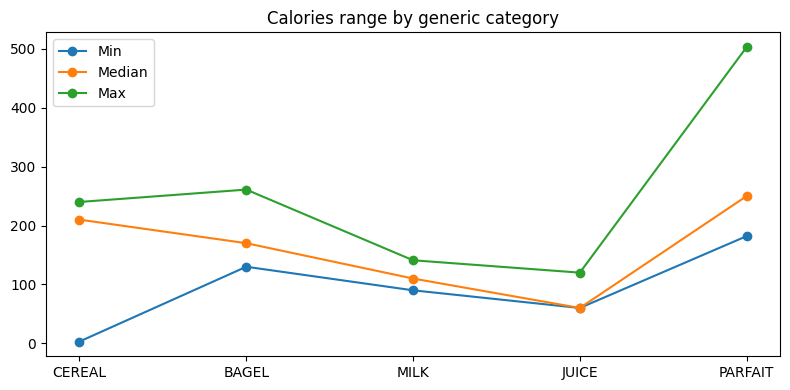

In [14]:
# Quick min/median/max plot for Calories across selected groups
if not stats_tbl.empty and "Calories" in nutr.columns:
    by_grp = []
    for key in GENERIC_SALES_KEYS:
        recs = nutr[nutr["_cat"].apply(lambda s: key in s if isinstance(s,set) else False)]
        if recs.empty: continue
        cal = pd.to_numeric(recs["Calories"], errors="coerce").dropna()
        if cal.empty: continue
        by_grp.append((key.upper(), cal.min(), cal.median(), cal.max()))
    if by_grp:
        labels, mins, meds, maxs = zip(*by_grp)
        fig = plt.figure(figsize=(8,4))
        x = np.arange(len(labels))
        plt.plot(x, mins, marker="o", label="Min")
        plt.plot(x, meds, marker="o", label="Median")
        plt.plot(x, maxs, marker="o", label="Max")
        plt.title("Calories range by generic category")
        plt.xticks(x, labels); plt.legend(); plt.tight_layout(); plt.show()

Several issue detectors are built:

-Missing values: Counts NaNs for nutrients.

-Unrealistic serving sizes: Flags GramsPerServing > 2000.

-Zero grams but positive nutrients: Impossible entries (e.g., 0g Coke with 100 calories).

-Duplicate recipe names: Same recipe name but different nutrition profiles.

Each issue is saved as a CSV in eda_outputs/.

In [15]:
# ---------- PART C: Data quality checks (CLEANING FOCUSED) ----------
issues = {}

nutr_cols_all = ["GramsPerServing","Calories","Protein","Total Fat","Saturated Fat","Trans Fat",
                 "Total Carbohydrate","Dietary Fiber","Total Sugars","Added Sugars","Sodium","Cholesterol"]
present = [c for c in nutr_cols_all if c in nutr.columns]


In [16]:
# Missing counts
miss = nutr[present].apply(pd.to_numeric, errors="coerce").isna().sum().sort_values(ascending=False)
issues["missing_counts"] = miss


In [17]:
# Unrealistic grams
if "GramsPerServing" in nutr.columns:
    nutr["GramsPerServing_num"] = pd.to_numeric(nutr["GramsPerServing"], errors="coerce")
    unreal_grams = nutr[nutr["GramsPerServing_num"] > 2000][["RecipeName","ServingSize","GramsPerServing"]]
    issues["grams_gt_2000"] = unreal_grams

In [18]:
# 0 grams but positive nutrients
if "GramsPerServing" in nutr.columns:
    zero_g = pd.to_numeric(nutr["GramsPerServing"], errors="coerce").fillna(0) <= 0.1
    pos_nutr = nutr[["Calories","Protein","Total Fat","Total Carbohydrate"]].apply(pd.to_numeric, errors="coerce").fillna(0).sum(axis=1) > 0
    impossible = nutr[zero_g & pos_nutr][["RecipeName","ServingSize","GramsPerServing","Calories","Protein","Total Fat","Total Carbohydrate"]]
    issues["grams_zero_with_nutrients"] = impossible


In [21]:
# Duplicate recipe names with differing nutrients
dups = nutr[nutr.duplicated(subset=["RecipeName"], keep=False)].sort_values("RecipeName")
issues["duplicate_recipe_names"] = dups[["RecipeName","ServingSize","GramsPerServing","Calories","Protein","Total Fat","Total Sugars"]]


In [22]:
# Save issues
for name, df_ in issues.items():
    outp = Path(OUT_DIR)/f"issue_{name}.csv"
    if isinstance(df_, pd.Series):
        df_.to_csv(outp, header=True)
    else:
        df_.to_csv(outp, index=False)

print("Issues written to:", OUT_DIR)

Issues written to: /Users/sirishag/Documents/fall-2025-group8/src/data/eda_outputs


Builds a demo table showing:

Generic sales item (e.g., “CEREAL”)
Example mapped recipes
Median Calories, Protein, Sugar

Justifies why median aggregation is sensible.

Saved as generic_median_demo.csv.

In [25]:
# ---------- PART D: Median proposal demo (table you can paste) ----------
def median_row(df, top_cols=("Calories","Protein","Total Sugars")):
    out = {}
    for c in top_cols:
        if c in df.columns:
            out[c] = float(pd.to_numeric(df[c], errors="coerce").median(skipna=True))
    return out

demo_rows = []
for key in ["cereal","bagel","milk","juice","parfait"]:
    recs = nutr[nutr["_cat"].apply(lambda s: key in s if isinstance(s,set) else False)].copy()
    if recs.empty: continue
    names = recs["RecipeName"].head(5).tolist()
    med   = median_row(recs, ("Calories","Protein","Total Sugars"))
    demo_rows.append({
        "sales_item_generic": key.upper(),
        "mapped_items_examples": ", ".join(names[:3]),
        **med
    })
median_demo = pd.DataFrame(demo_rows)
median_demo.to_csv(Path(OUT_DIR)/"generic_median_demo.csv", index=False)
print("\nSaved:", Path(OUT_DIR)/"generic_median_demo.csv")


Saved: /Users/sirishag/Documents/fall-2025-group8/src/data/eda_outputs/generic_median_demo.csv


In [26]:
# ---------- PART E: One-page, copy-friendly summaries ----------
# 1) Headline counts
pd.DataFrame([summary]).to_csv(Path(OUT_DIR)/"00_headline_counts.csv", index=False)


In [27]:
# 2) Clean vs Ambiguous vs Missing snapshot
def pct(x, n): 
    return f"{x} ({(x/max(n,1))*100:.1f}%)"
clean_groups = stats_tbl[stats_tbl["group"].isin([g.upper() for g in GENERIC_SALES_KEYS])]
clean_snapshot = clean_groups.groupby("group")["metric"].count().reset_index(name="metrics_covered")
clean_snapshot.to_csv(Path(OUT_DIR)/"01_clean_groups_snapshot.csv", index=False)

ambiguous_note = pd.DataFrame({
    "note":[
        "Bagel categories have wider nutrient spread if with cream cheese vs plain.",
        "Parfaits vary by toppings; treat allergens separately.",
        "Sandwiches/entrees vary widely by recipe; do not median indiscriminately."
    ]
})
ambiguous_note.to_csv(Path(OUT_DIR)/"02_ambiguous_notes.csv", index=False)

missing_snapshot = miss.reset_index()
missing_snapshot.columns = ["nutrient","missing_count"]
missing_snapshot.to_csv(Path(OUT_DIR)/"03_missing_snapshot.csv", index=False)

print("\n✅ EDA + Cleaning outputs written to:", OUT_DIR)
print("Files:")
for p in sorted(Path(OUT_DIR).glob("*.csv")):
    print(" -", p.name)


✅ EDA + Cleaning outputs written to: /Users/sirishag/Documents/fall-2025-group8/src/data/eda_outputs
Files:
 - 00_headline_counts.csv
 - 01_clean_groups_snapshot.csv
 - 02_ambiguous_notes.csv
 - 03_missing_snapshot.csv
 - generic_groups_stats.csv
 - generic_median_demo.csv
 - issue_duplicate_recipe_names.csv
 - issue_grams_gt_2000.csv
 - issue_grams_zero_with_nutrients.csv
 - issue_missing_counts.csv
 - recipes_bagel.csv
 - recipes_cereal.csv
 - recipes_juice.csv
 - recipes_milk.csv
 - recipes_parfait.csv
 - sales_items_with_cats.csv
 - summary_counts.csv
 - top_sales_items.csv


00_headline_counts.csv → unique sales vs. recipes.

01_clean_groups_snapshot.csv → clean groups like cereal/milk.

02_ambiguous_notes.csv → text notes on bagels, parfaits, etc.

03_missing_snapshot.csv → nutrients missing counts.